In [9]:
import pandas as pd
import numpy as np

from plotnine import * 
from mizani.formatters import percent_format, date_format
from mizani.breaks import date_breaks
from itertools import product
from sklearn.model_selection import (
  train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Lasso, Ridge

from functions import *

import matplotlib.pyplot as plt

In [23]:
data = pd.read_csv('Data/non_nan_data.csv')

data = data.drop(['DK1_spot'], axis=1)
data = data.drop(['sun_mean', 'wind_mean'], axis=1)

data['DK2_spot'] = data['DK2_spot'] - data['DK2_spot'].mean()

# Lag DK2_spot by 1 hours
data['DK2_spot_lag'] = data['DK2_spot'].shift(1)

data = data.dropna()

data = data.reset_index(drop=True)

hour_dummies = sdummy(len(data), 24)

# Make hour dummies to dataframe
# hour_dummies = pd.DataFrame(hour_dummies, columns=['hour_'+str(i) for i in range(24)])

# Add hour dummies to data
# data = pd.concat([data, hour_dummies], axis=1)

# Assume 'data' is your full dataset and 'ret_excess' is the target column
data.drop(columns=["DATE"], inplace=True)


cols_to_normalize = [col for col in data.columns if col.startswith('sun_') or col.startswith('wind_')]
data[cols_to_normalize] = (data[cols_to_normalize] - data[cols_to_normalize].min()) / (data[cols_to_normalize].max() - data[cols_to_normalize].min())
# data = (data - data.min()) / (data.max() - data.min())

data

,DK2_spot,sun_06019,sun_06031,sun_06041,sun_06056,sun_06058,sun_06065,sun_06068,sun_06072,sun_06079,...,wind_06170,wind_06174,wind_06180,wind_06181,wind_06183,wind_06188,wind_06190,wind_06193,wind_06197,DK2_spot_lag
0,-367.096160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.276699,0.290541,0.362162,0.230769,0.425197,0.158163,0.333333,0.250980,0.142857,-360.606162
1,-370.006163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.378378,0.335135,0.307692,0.429134,0.193878,0.356481,0.215686,0.200000,-367.096160
2,-370.306159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.297297,0.416216,0.320513,0.464567,0.147959,0.333333,0.074510,0.200000,-370.006163
3,-372.616156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.276699,0.398649,0.502703,0.275641,0.543307,0.147959,0.379630,0.000000,0.180952,-370.306159
4,-383.806159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.452703,0.475676,0.378205,0.503937,0.224490,0.407407,0.050980,0.200000,-372.616156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93616,-76.796149,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.247573,0.304054,0.335135,0.179487,0.210630,0.214286,0.333333,0.231373,0.328571,-43.226172
93617,-116.786170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199029,0.229730,0.275676,0.141026,0.194636,0.214286,0.310185,0.223529,0.361905,-76.796149
93618,-159.456153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.247573,0.324324,0.308108,0.134615,0.199951,0.198980,0.356481,0.235294,0.338095,-116.786170
93619,-196.236151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.223301,0.331081,0.308108,0.128205,0.209892,0.250000,0.407407,0.192157,0.342857,-159.456153


In [ ]:

# Define grid search parameters
x_values = np.exp(np.log(10) * np.linspace(np.log10(0.00001), np.log10(10), 30))
y_values = np.linspace(0, 1, 10)
grid = pd.DataFrame(np.array(np.meshgrid(x_values, y_values)).T.reshape(-1, 2), columns=["x", "y"])

# Placeholder for results
results = []

# Define the linear fit function
def linear_fit_function(x, y, X_train, X_test, y_train, y_test):
    # Create and fit the ElasticNet model
    model = ElasticNet(alpha=x, l1_ratio=y, fit_intercept=False)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate mean squared prediction error (MSPE)
    sq_error = (y_pred - y_test) ** 2
    mspe = np.mean(sq_error)

    print(x, y)
    return mspe

# Example dataset split (replace 'data' with your actual dataset)
# Assume 'data' has the necessary features and 'ret_excess' as the target variable
X = data.drop(columns=["DK2_spot"])
y = data["DK2_spot"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the linear fit function over the grid
for _, row in grid.iterrows():
    x, y = row["x"], row["y"]
    mspe = linear_fit_function(x, y, X_train, X_test, y_train, y_test)
    results.append(mspe)

# Combine the results into a final DataFrame
final_mspe = pd.concat([grid, pd.DataFrame(results, columns=["mspe"])], axis=1)


# Output the results
print(final_mspe)


In [26]:
# Save final_mspe to csv
final_mspe.to_csv('Data/final_mspe.csv', index=False)

# Load final_mspe from csv
final_mspe = pd.read_csv('Data/final_mspe.csv')

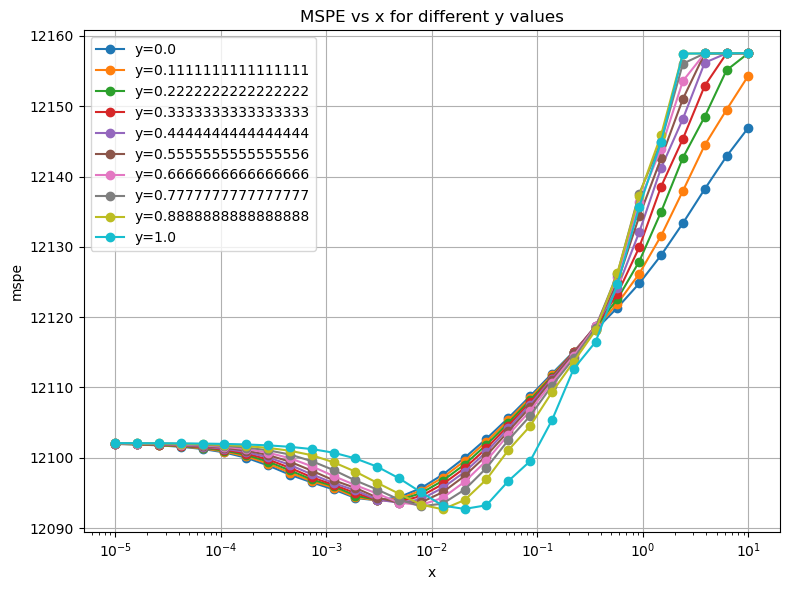

In [27]:
plt.figure(figsize=(8, 6))
for y_value in final_mspe['y'].unique():
    subset = final_mspe[final_mspe['y'] == y_value]
    plt.plot(subset['x'], subset['mspe'], marker='o', label=f'y={y_value}')

plt.xlabel('x')
plt.ylabel('mspe')
plt.title('MSPE vs x for different y values')
plt.legend()
plt.xscale('log')  # since x values vary over several orders of magnitude
plt.grid(True)
plt.tight_layout()

plt.show()